In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt 
import seaborn as sns 
import xgboost as xgb
from scipy import stats
from scipy.stats import norm, skew
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error,accuracy_score
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering, DBSCAN

from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingRegressor, RandomForestClassifier
from lightgbm import LGBMRegressor
from sklearn.pipeline import make_pipeline
from mlxtend.regressor import StackingCVRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from pandas.api.types import CategoricalDtype
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV, Lasso, Ridge
import os
print(os.listdir('.'))
train = pd.read_csv('input2/train.csv')
test = pd.read_csv('input2/test.csv')

all_data = pd.concat((train, test), axis=0, sort=False).reset_index(drop=True)

['.ipynb_checkpoints', 'Analise_Variavel_Alley.ipynb', 'Analise_Variavel_MiscFeature.ipynb', 'Analise_Variavel_Qualidade_Piscina.ipynb', 'Artigo_Medium.ipynb', 'Fast_through_variables_categorical.ipynb', 'Fast_through_variables_modelagem.ipynb', 'Fast_through_variables_numerical.ipynb', 'HousePriceV012-20200414.ipynb', 'input2', 'submissionv020-xgbbost.csv', 'submissionv021-xgbbost.csv']


In [3]:
all_data['FireplaceQu'] = all_data['FireplaceQu'].fillna('NA')

# Criando novas variaveis
all_data['FireplaceQu'] = all_data['FireplaceQu'].fillna('NA')
all_data['FireplaceQu'] = all_data['FireplaceQu'].apply(lambda x:
                                                        5 if x in ['Ex'] else
                                                        4 if x in ['Gd'] else
                                                        3 if x in ['TA'] else
                                                        2 if x in ['Fa'] else
                                                        1 if x in ['Po'] 
                                                        else 0)
all_data['FireplaceQuFireplaces'] = all_data['FireplaceQu'] * all_data['Fireplaces'] 



# Lotfrontage
dbfilter = all_data[['LotArea','LotFrontage']].copy()
X = dbfilter.iloc[:, [0,0]].values
X = StandardScaler().fit_transform(X)
hc = AgglomerativeClustering(n_clusters = 4, affinity = 'euclidean', linkage ='ward')
y_hc=hc.fit_predict(X)
all_data['ClusterLotArea'] = y_hc
all_data["LotFrontage"] = all_data.groupby("ClusterLotArea")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

all_data.loc[all_data.index==2126, "GarageFinish"]='Unf'
all_data.loc[all_data.index==2126, "GarageQual"]='Po'
all_data.loc[all_data.index==2126, "GarageYrBlt"]=all_data[all_data["GarageQual"]=='Po']['GarageYrBlt'].min()
all_data.loc[all_data.index==2126, "GarageCond"]='Po'
all_data.loc[all_data.index==2576, "GarageCars"]=0
all_data.loc[all_data.index==2576, "GarageArea"]=0
all_data['GarageFinish'] = all_data['GarageFinish'].fillna('NA')
all_data['GarageQual'] = all_data['GarageQual'].fillna('NA')
all_data['GarageCond'] = all_data['GarageCond'].fillna('NA')
all_data['GarageType'] = all_data['GarageType'].fillna('NA')
all_data['GarageYrBlt'] = all_data['GarageYrBlt'].fillna(0)

all_data.loc[all_data.index.isin([2348,1487,948]), "BsmtExposure"]='Av'
all_data.loc[(all_data['BsmtFinSF1']==0) & (all_data['BsmtCond'].isnull()), "BsmtCond"] = 'NA'
all_data.loc[(all_data['BsmtFinSF1']==0) & (all_data['BsmtQual'].isnull()), "BsmtQual"] = 'NA'
all_data.loc[(all_data['BsmtFinSF1']==0) & (all_data['BsmtFinType2'].isnull()), "BsmtFinType2"] = 'NA'
all_data.loc[(all_data['BsmtFinSF1']==0) & (all_data['BsmtFinType1'].isnull()), "BsmtFinType1"] = 'NA'
all_data.loc[(all_data['BsmtFinSF1']==0) & (all_data['BsmtExposure'].isnull()), "BsmtExposure"] = 'NA'
all_data.loc[all_data.index==2120,['BsmtExposure','BsmtCond','BsmtQual','BsmtFinType2','BsmtFinType1','BsmtFullBath', 'BsmtHalfBath','BsmtUnfSF','BsmtFinSF2','BsmtFinSF1']] = all_data[(all_data.index==1856)][['BsmtExposure','BsmtCond','BsmtQual','BsmtFinType2','BsmtFinType1','BsmtFullBath','BsmtHalfBath','BsmtUnfSF','BsmtFinSF2','BsmtFinSF1']].values
all_data.loc[(all_data.index==2040), "BsmtCond"]='Gd'
all_data.loc[(all_data.index==2185), "BsmtCond"]='TA'
all_data.loc[(all_data.index==2524), "BsmtCond"]='TA'
all_data['TotalBsmtSF'] = all_data['TotalBsmtSF'].fillna(0)
all_data['BsmtFinType2'] = all_data['BsmtFinType2'].fillna('Unf')
all_data['BsmtFullBath'] = all_data['BsmtFullBath'].fillna(0)
all_data['BsmtHalfBath'] = all_data['BsmtHalfBath'].fillna(0)
all_data['MasVnrType'] = all_data['MasVnrType'].fillna('None')
all_data['MasVnrArea'] = all_data['MasVnrArea'].fillna(0)
all_data.loc[(all_data.index.isin([2216,2904])), "MSZoning"]='RL'
all_data.loc[(all_data.index.isin([1915,2250])), "MSZoning"]='RM'
all_data['Utilities'] = all_data['Utilities'].fillna('ELO')
all_data['Functional'] = all_data['Functional'].fillna('Typ')
all_data['SaleType'] = all_data['SaleType'].fillna('WD')
all_data['KitchenQual'] = all_data['KitchenQual'].fillna('TA')
all_data['Exterior1st'] = all_data['Exterior1st'].fillna('Other')
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna('Other')
all_data['Electrical'] = all_data['Electrical'].fillna('SBrkr')

train = train.drop(['PoolQC','MiscFeature','Alley','Fence','FireplaceQu','Fireplaces','Street','Utilities'], 1).copy()
test = test.drop(['PoolQC','MiscFeature','Alley','Fence','FireplaceQu','Fireplaces','Street','Utilities'], 1).copy()
all_data = all_data.drop(['PoolQC','MiscFeature','Alley','Fence','FireplaceQu','Fireplaces','ClusterLotArea','Street','Utilities'], 1).copy()

# deletado por fraco porder de separação 
all_data = all_data.drop(['LandSlope','Condition1','Condition2','RoofStyle','RoofMatl',
                          'RoofMatl','BsmtFinType2','Heating', 'Electrical','Functional', 'GarageCond', 
                          'SaleType','SaleCondition'], 1).copy()


# Ajustes de classificações
all_data.loc[(all_data['MSZoning']=='RM'), "MSZoning"] = 'RH'

all_data.loc[(all_data['LotShape']=='IR3'), "LotShape"] = 'IR2'

all_data.loc[(all_data['LandContour']=='Low'), "LandContour"] = 'HLS'

all_data.loc[(all_data['LotConfig']=='FR2'), "LotConfig"] = 'Corner'
all_data.loc[(all_data['LotConfig']=='FR3'), "LotConfig"] = 'CulDSac'

# SEPARACAO DOS BAIRROS
dbfilter = all_data[(~all_data['Neighborhood'].isnull()) & (all_data['SalePrice'] > 0)][['Neighborhood','SalePrice']].copy()
dbfilter['media']=all_data['Neighborhood'].map(dbfilter.groupby(["Neighborhood"])["SalePrice"].mean())
dbfilter2 = dbfilter.copy()
X = dbfilter2.iloc[:, [2,2]].values
X = StandardScaler().fit_transform(X)
hc = AgglomerativeClustering(n_clusters = 6, affinity = 'euclidean', linkage ='ward')
y_hc=hc.fit_predict(X)
dbfilter2['Cluster'] = y_hc
mean_encode = dbfilter2.groupby('Neighborhood')['Cluster'].max().copy()
all_data['Cluster'] = all_data['Neighborhood'].map(mean_encode).copy()
mean_encode = dbfilter2.groupby('Cluster')['Neighborhood'].max().copy()
all_data['Neighborhood'] = all_data['Cluster'].map(mean_encode).copy()
all_data = all_data.drop(['Cluster'], 1).copy()

all_data.loc[(all_data['BldgType']=='2fmCon'), "BldgType"] = 'Duplex'
all_data.loc[(all_data['BldgType']=='Twnhs'), "BldgType"] = 'Duplex'
all_data.loc[(all_data['BldgType']=='TwnhsE'), "BldgType"] = '1Fam'

#SEPARACAO DOS HouseStyle
dbfilter = all_data[(~all_data['HouseStyle'].isnull()) & (all_data['SalePrice'] > 0)][['HouseStyle','SalePrice']].copy()
dbfilter['media']=all_data['HouseStyle'].map(dbfilter.groupby(["HouseStyle"])["SalePrice"].mean())
dbfilter2 = dbfilter.copy()
X = dbfilter2.iloc[:, [2,2]].values
X = StandardScaler().fit_transform(X)
hc = AgglomerativeClustering(n_clusters = 3, affinity = 'euclidean', linkage ='ward')
y_hc=hc.fit_predict(X)
dbfilter2['Cluster'] = y_hc
mean_encode = dbfilter2.groupby('HouseStyle')['Cluster'].max().copy()
all_data['Cluster'] = all_data['HouseStyle'].map(mean_encode).copy()
mean_encode = dbfilter2.groupby('Cluster')['HouseStyle'].max().copy()
all_data['HouseStyle'] = all_data['Cluster'].map(mean_encode).copy()
all_data = all_data.drop(['Cluster'], 1).copy()

# separacao Exterior1st
dbfilter = all_data[(~all_data['Exterior1st'].isnull()) & (all_data['SalePrice'] > 0)][['Exterior1st','SalePrice']].copy()
dbfilter['media']=all_data['Exterior1st'].map(dbfilter.groupby(["Exterior1st"])["SalePrice"].mean())
dbfilter2 = dbfilter.copy()
X = dbfilter2.iloc[:, [2,2]].values
X = StandardScaler().fit_transform(X)
hc = AgglomerativeClustering(n_clusters = 3, affinity = 'euclidean', linkage ='ward')
y_hc=hc.fit_predict(X)
dbfilter2['Cluster'] = y_hc
mean_encode = dbfilter2.groupby('Exterior1st')['Cluster'].max().copy()
all_data['Cluster'] = all_data['Exterior1st'].map(mean_encode).copy()
mean_encode = dbfilter2.groupby('Cluster')['Exterior1st'].max().copy()
all_data['Exterior1st'] = all_data['Cluster'].map(mean_encode).copy()
all_data = all_data.drop(['Cluster'], 1).copy()

# separacao Exterior2nd
dbfilter = all_data[(~all_data['Exterior2nd'].isnull()) & (all_data['SalePrice'] > 0)][['Exterior2nd','SalePrice']].copy()
dbfilter['media']=all_data['Exterior2nd'].map(dbfilter.groupby(["Exterior2nd"])["SalePrice"].mean())
dbfilter2 = dbfilter.copy()
#dbfilter2 = train.groupby('Exterior2nd')['SalePrice'].median().to_frame(name = 'Media').reset_index().sort_values('Media',ascending=True).copy()
#dbfilter2['media'] = np.log1p(dbfilter2['media']).copy()
X = dbfilter2.iloc[:, [2,2]].values
X = StandardScaler().fit_transform(X)
hc = AgglomerativeClustering(n_clusters = 3, affinity = 'euclidean', linkage ='ward')
y_hc=hc.fit_predict(X)
dbfilter2['Cluster'] = y_hc
mean_encode = dbfilter2.groupby('Exterior2nd')['Cluster'].max().copy()
all_data['Cluster'] = all_data['Exterior2nd'].map(mean_encode).copy()
mean_encode = dbfilter2.groupby('Cluster')['Exterior2nd'].max().copy()
all_data['Exterior2nd'] = all_data['Cluster'].map(mean_encode).copy()
all_data = all_data.drop(['Cluster'], 1).copy()

all_data.loc[(all_data['MasVnrType']=='BrkCmn'), "MasVnrType"] = 'None'

# separacao Exterior2nd
dbfilter = all_data[(~all_data['ExterCond'].isnull()) & (all_data['SalePrice'] > 0)][['ExterCond','SalePrice']].copy()
dbfilter['media']=all_data['ExterCond'].map(dbfilter.groupby(["ExterCond"])["SalePrice"].mean())
dbfilter2 = dbfilter.copy()
#dbfilter2 = train.groupby('Exterior2nd')['SalePrice'].median().to_frame(name = 'Media').reset_index().sort_values('Media',ascending=True).copy()
#dbfilter2['media'] = np.log1p(dbfilter2['media']).copy()
X = dbfilter2.iloc[:, [2,2]].values
X = StandardScaler().fit_transform(X)
hc = AgglomerativeClustering(n_clusters = 2, affinity = 'euclidean', linkage ='ward')
y_hc=hc.fit_predict(X)
dbfilter2['Cluster'] = y_hc
mean_encode = dbfilter2.groupby('ExterCond')['Cluster'].max().copy()
all_data['Cluster'] = all_data['ExterCond'].map(mean_encode).copy()
mean_encode = dbfilter2.groupby('Cluster')['ExterCond'].max().copy()
all_data['ExterCond'] = all_data['Cluster'].map(mean_encode).copy()
all_data = all_data.drop(['Cluster'], 1).copy()

# separacao Foundation
dbfilter = all_data[(~all_data['Foundation'].isnull()) & (all_data['SalePrice'] > 0)][['Foundation','SalePrice']].copy()
dbfilter['media']=all_data['Foundation'].map(dbfilter.groupby(["Foundation"])["SalePrice"].mean())
dbfilter2 = dbfilter.copy()
#dbfilter2 = train.groupby('Exterior2nd')['SalePrice'].median().to_frame(name = 'Media').reset_index().sort_values('Media',ascending=True).copy()
#dbfilter2['media'] = np.log1p(dbfilter2['media']).copy()
X = dbfilter2.iloc[:, [2,2]].values
X = StandardScaler().fit_transform(X)
hc = AgglomerativeClustering(n_clusters = 3, affinity = 'euclidean', linkage ='ward')
y_hc=hc.fit_predict(X)
dbfilter2['Cluster'] = y_hc
mean_encode = dbfilter2.groupby('Foundation')['Cluster'].max().copy()
all_data['Cluster'] = all_data['Foundation'].map(mean_encode).copy()
mean_encode = dbfilter2.groupby('Cluster')['Foundation'].max().copy()
all_data['Foundation'] = all_data['Cluster'].map(mean_encode).copy()
all_data = all_data.drop(['Cluster'], 1).copy()

all_data.loc[(all_data['BsmtQual']=='BrkCmn'), "BsmtQual"] = 'None'
all_data.loc[(all_data['BsmtExposure']=='Mn'), "BsmtExposure"] = 'Av'

# separacao BsmtFinType1
dbfilter = all_data[(~all_data['BsmtFinType1'].isnull()) & (all_data['SalePrice'] > 0)][['BsmtFinType1','SalePrice']].copy()
dbfilter['media']=all_data['BsmtFinType1'].map(dbfilter.groupby(["BsmtFinType1"])["SalePrice"].mean())
dbfilter2 = dbfilter.copy()
#dbfilter2 = train.groupby('Exterior2nd')['SalePrice'].median().to_frame(name = 'Media').reset_index().sort_values('Media',ascending=True).copy()
#dbfilter2['media'] = np.log1p(dbfilter2['media']).copy()
X = dbfilter2.iloc[:, [2,2]].values
X = StandardScaler().fit_transform(X)
hc = AgglomerativeClustering(n_clusters = 4, affinity = 'euclidean', linkage ='ward')
y_hc=hc.fit_predict(X)
dbfilter2['Cluster'] = y_hc
mean_encode = dbfilter2.groupby('BsmtFinType1')['Cluster'].max().copy()
all_data['Cluster'] = all_data['BsmtFinType1'].map(mean_encode).copy()
mean_encode = dbfilter2.groupby('Cluster')['BsmtFinType1'].max().copy()
all_data['BsmtFinType1'] = all_data['Cluster'].map(mean_encode).copy()
all_data = all_data.drop(['Cluster'], 1).copy()

# separacao HeatingQC
dbfilter = all_data[(~all_data['HeatingQC'].isnull()) & (all_data['SalePrice'] > 0)][['HeatingQC','SalePrice']].copy()
dbfilter['media']=all_data['HeatingQC'].map(dbfilter.groupby(["HeatingQC"])["SalePrice"].mean())
dbfilter2 = dbfilter.copy()
#dbfilter2 = train.groupby('Exterior2nd')['SalePrice'].median().to_frame(name = 'Media').reset_index().sort_values('Media',ascending=True).copy()
#dbfilter2['media'] = np.log1p(dbfilter2['media']).copy()
X = dbfilter2.iloc[:, [2,2]].values
X = StandardScaler().fit_transform(X)
hc = AgglomerativeClustering(n_clusters = 4, affinity = 'euclidean', linkage ='ward')
y_hc=hc.fit_predict(X)
dbfilter2['Cluster'] = y_hc
mean_encode = dbfilter2.groupby('HeatingQC')['Cluster'].max().copy()
all_data['Cluster'] = all_data['HeatingQC'].map(mean_encode).copy()
mean_encode = dbfilter2.groupby('Cluster')['HeatingQC'].max().copy()
all_data['HeatingQC'] = all_data['Cluster'].map(mean_encode).copy()
all_data = all_data.drop(['Cluster'], 1).copy()

# separacao GarageType
dbfilter = all_data[(~all_data['GarageType'].isnull()) & (all_data['SalePrice'] > 0)][['GarageType','SalePrice']].copy()
dbfilter['media']=all_data['GarageType'].map(dbfilter.groupby(["GarageType"])["SalePrice"].mean())
dbfilter2 = dbfilter.copy()
#dbfilter2 = train.groupby('Exterior2nd')['SalePrice'].median().to_frame(name = 'Media').reset_index().sort_values('Media',ascending=True).copy()
#dbfilter2['media'] = np.log1p(dbfilter2['media']).copy()
X = dbfilter2.iloc[:, [2,2]].values
X = StandardScaler().fit_transform(X)
hc = AgglomerativeClustering(n_clusters = 4, affinity = 'euclidean', linkage ='ward')
y_hc=hc.fit_predict(X)
dbfilter2['Cluster'] = y_hc
mean_encode = dbfilter2.groupby('GarageType')['Cluster'].max().copy()
all_data['Cluster'] = all_data['GarageType'].map(mean_encode).copy()
mean_encode = dbfilter2.groupby('Cluster')['GarageType'].max().copy()
all_data['GarageType'] = all_data['Cluster'].map(mean_encode).copy()
all_data = all_data.drop(['Cluster'], 1).copy()

# separacao GarageQual
dbfilter = all_data[(~all_data['GarageQual'].isnull()) & (all_data['SalePrice'] > 0)][['GarageQual','SalePrice']].copy()
dbfilter['media']=all_data['GarageQual'].map(dbfilter.groupby(["GarageQual"])["SalePrice"].mean())
dbfilter2 = dbfilter.copy()
#dbfilter2 = train.groupby('Exterior2nd')['SalePrice'].median().to_frame(name = 'Media').reset_index().sort_values('Media',ascending=True).copy()
#dbfilter2['media'] = np.log1p(dbfilter2['media']).copy()
X = dbfilter2.iloc[:, [2,2]].values
X = StandardScaler().fit_transform(X)
hc = AgglomerativeClustering(n_clusters = 3, affinity = 'euclidean', linkage ='ward')
y_hc=hc.fit_predict(X)
dbfilter2['Cluster'] = y_hc
mean_encode = dbfilter2.groupby('GarageQual')['Cluster'].max().copy()
all_data['Cluster'] = all_data['GarageQual'].map(mean_encode).copy()
mean_encode = dbfilter2.groupby('Cluster')['GarageQual'].max().copy()
all_data['GarageQual'] = all_data['Cluster'].map(mean_encode).copy()
all_data = all_data.drop(['Cluster'], 1).copy()
all_data['GarageQual'] = all_data['GarageQual'].apply(lambda x:
                                                      1 if x in ['Po'] else
                                                      2 if x in ['TA']
                                                      else 3)

all_data.loc[(all_data['PavedDrive']=='P'), "PavedDrive"] = 'N'

# separacao MSSubClass
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str).apply(lambda x: 'MS'+x )
dbfilter = all_data[(~all_data['MSSubClass'].isnull()) & (all_data['SalePrice'] > 0)][['MSSubClass','SalePrice']].copy()
dbfilter['media']=all_data['MSSubClass'].map(dbfilter.groupby(["MSSubClass"])["SalePrice"].mean())
dbfilter2 = dbfilter.copy()
#dbfilter2 = train.groupby('Exterior2nd')['SalePrice'].median().to_frame(name = 'Media').reset_index().sort_values('Media',ascending=True).copy()
#dbfilter2['media'] = np.log1p(dbfilter2['media']).copy()
X = dbfilter2.iloc[:, [2,2]].values
X = StandardScaler().fit_transform(X)
hc = AgglomerativeClustering(n_clusters = 5, affinity = 'euclidean', linkage ='ward')
y_hc=hc.fit_predict(X)
dbfilter2['Cluster'] = y_hc
mean_encode = dbfilter2.groupby('MSSubClass')['Cluster'].max().copy()
all_data['Cluster'] = all_data['MSSubClass'].map(mean_encode).copy()
mean_encode = dbfilter2.groupby('Cluster')['MSSubClass'].max().copy()
all_data['MSSubClass'] = all_data['Cluster'].map(mean_encode).copy()
all_data = all_data.drop(['Cluster'], 1).copy()

# separacao OverallCond
all_data['OverallCond'] = all_data['OverallCond'].apply(str).apply(lambda x: 'OC'+x )
dbfilter = all_data[(~all_data['OverallCond'].isnull()) & (all_data['SalePrice'] > 0)][['OverallCond','SalePrice']].copy()
dbfilter['media']=all_data['OverallCond'].map(dbfilter.groupby(["OverallCond"])["SalePrice"].mean())
dbfilter2 = dbfilter.copy()
#dbfilter2 = train.groupby('Exterior2nd')['SalePrice'].median().to_frame(name = 'Media').reset_index().sort_values('Media',ascending=True).copy()
#dbfilter2['media'] = np.log1p(dbfilter2['media']).copy()
X = dbfilter2.iloc[:, [2,2]].values
X = StandardScaler().fit_transform(X)
hc = AgglomerativeClustering(n_clusters = 3, affinity = 'euclidean', linkage ='ward')
y_hc=hc.fit_predict(X)
dbfilter2['Cluster'] = y_hc
mean_encode = dbfilter2.groupby('OverallCond')['Cluster'].max().copy()
all_data['Cluster'] = all_data['OverallCond'].map(mean_encode).copy()
mean_encode = dbfilter2.groupby('Cluster')['OverallCond'].max().copy()
all_data['OverallCond'] = all_data['Cluster'].map(mean_encode).copy()
all_data = all_data.drop(['Cluster'], 1).copy()

all_data['MoSold'] = all_data['MoSold'].apply(str).apply(lambda x: 'MS'+x )

### CRIACAO DE VARIAVEIS NUMERICAS
all_data['TotalPorch'] = all_data['OpenPorchSF'] + all_data['EnclosedPorch'] + all_data['3SsnPorch'] + all_data['ScreenPorch']
all_data['BsmtBathTot'] = all_data['BsmtFullBath'] + (all_data['BsmtHalfBath']*0.5)
# deletado variaveis numericas
all_data = all_data.drop(['OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch', 'Id', 'BsmtUnfSF', 
                          'BsmtFinSF2', 'BsmtFinSF1','KitchenAbvGr', 'YrSold', 'MoSold','LowQualFinSF','MiscVal',
                         'GarageArea','1stFlrSF', 'BsmtFullBath','BsmtHalfBath'], 1).copy()


#DELETAR OUTLIER
all_data = all_data.drop(all_data[(all_data['GrLivArea']>4000) & (all_data['SalePrice']<300000)].index).copy()
all_data = all_data.drop(all_data[(all_data['TotRmsAbvGrd']>13) & (all_data['SalePrice']<300000)].index).copy()
all_data = all_data.drop(all_data[(all_data['MasVnrArea']>1590) & (all_data['SalePrice']<300000)].index).copy()

In [4]:
#SEM REDUZIR DIMENSÕES
all_data = pd.get_dummies(all_data)
train = all_data[(all_data['SalePrice'].notnull() == True)]
test = all_data[(all_data['SalePrice'].notnull() == False)]
#train = train.reset_index(drop=True)
#test = test.reset_index(drop=True)

if 'SalePrice' in test.columns:
    test = test.drop('SalePrice', axis=1)

    
train = np.log1p(train).copy()
test = np.log1p(test).copy()

In [5]:
#DIVISÃO DA AMOSTRA
X_train, X_test, y_train, y_test = train_test_split(train.drop('SalePrice', axis=1), 
                                                    train['SalePrice'], test_size=0.3, random_state=101)

C:\Users\MANAGER\AppData\Local\Programs\Python\Python38\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


SCORE train 0.9820197248457001
SCORE test 0.9147070066988978
MAE: 0.08282154721667906
MSE: 0.01364428053456782
RMSE: 0.11680873483848637


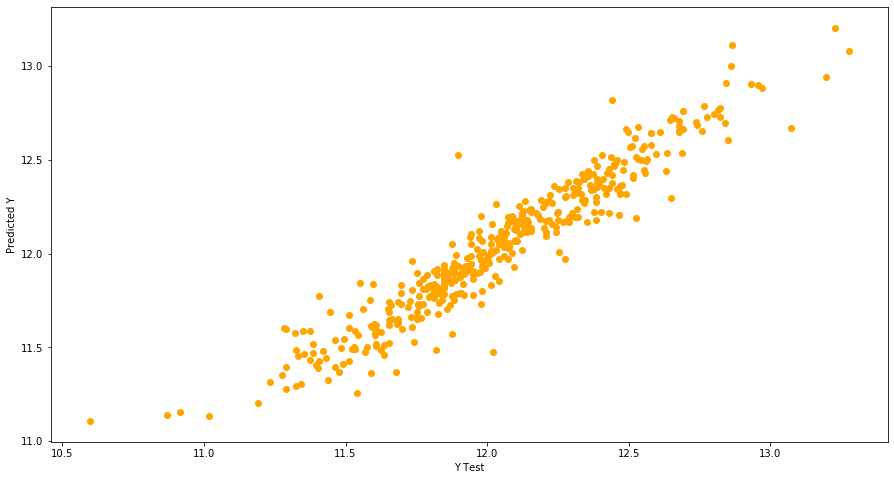

In [8]:
# Define model
xgbbost =  xgb.XGBRegressor(objective ='reg:squarederror',
                                n_estimators=2000, 
                                learning_rate=0.02, n_jobs=2, max_depth=3,random_state=101, early_stopping_rounds=10)
model = xgbbost
#modelKfold = gbr
# Preprocessing of training data, fit model 
#model.fit(X_train, y_train)

#Preprocessing of training data, fit model  stack_gen
# treinar os dados com separacao entre treino e teste
model.fit(X_train, y_train)

# Preprocessing of validation data, get predictions
preds = model.predict(X_test)
#y_test = np.expm1(y_test).copy() 
#preds = np.expm1(preds).copy()
print('SCORE train',model.score(X_train, y_train))
print('SCORE test',model.score(X_test, y_test))
print('MAE:', mean_absolute_error(y_test, preds))
print('MSE:', mean_squared_error(y_test, preds))
print('RMSE:', np.sqrt(mean_squared_error(y_test, preds)))
#REALIZAÇAO DE CROSS-VALIDATION
#score = cv_rmse(model, train)
#print("RMSE-KFOLD: {:.4f} ({:.4f})\n".format(score.mean(), score.std()),  )

y_test.reset_index(inplace=True, drop=True)
plt.figure(figsize=(15,8))
plt.scatter(y_test,preds, c='orange')
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')
plt.show()

plt.figure(figsize=(16,8))
plt.plot(y_test,label ='Test')
plt.plot(preds, label = 'predict')
plt.show()

In [7]:
xgbbost =  xgb.XGBRegressor(objective ='reg:squarederror',
                                n_estimators=2000, 
                                learning_rate=0.02, n_jobs=2, max_depth=3,random_state=101, early_stopping_rounds=10)
model = xgbbost
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)
train_all = train.drop('SalePrice', axis=1).copy()
y_all = train['SalePrice'].copy()
rmse = np.sqrt(-cross_val_score(model, train_all, y_all, scoring="neg_mean_squared_error", cv=kfolds))
print('RMSE', rmse)

C:\Users\MANAGER\AppData\Local\Programs\Python\Python38\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\MANAGER\AppData\Local\Programs\Python\Python38\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\MANAGER\AppData\Local\Programs\Python\Python38\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\MANAGER\AppData\Local\Programs\Python\Python38\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\MANAGER\AppData\Local\Programs\Python\Python38\lib\site-packages\xgboost\core.py:58

RMSE [0.10232016 0.1222044  0.10383628 0.13159212 0.13703055 0.12583483
 0.12173616 0.11998466 0.12511216 0.11134234]


In [145]:
rmse.mean()
model.fit(train_all, y_all)
print('SCORE train',model.score(train_all, y_all))

C:\Users\MANAGER\AppData\Local\Programs\Python\Python38\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


SCORE train 0.9764320211574528


In [146]:
X_trainA = X_train.copy()
#X_train['importancia'] = pd.Series(xgbbost.feature_importances_)
X_Analise = pd.Series(X_trainA.columns.values).to_frame(name = 'Colunas')
X_Analise['importancia'] = pd.Series(model.feature_importances_)
X_Analise.sort_values('importancia',ascending=False).head(10)

,Colunas,importancia
99,GarageType_Attchd,0.125397
29,MSZoning_RL,0.088474
14,GarageCars,0.077614
71,BsmtQual_Ex,0.058263
82,BsmtExposure_Gd,0.038553
18,FireplaceQuFireplaces,0.036716
8,GrLivArea,0.035697
2,OverallQual,0.033751
15,GarageQual,0.030029
4,YearRemodAdd,0.023495


In [148]:
preds_test = model.predict(test)
preds_test = np.expm1(preds_test).copy() 
preds_test
# Save predictions in format used for competition scoring
output = pd.DataFrame({'Id': test.index+1,
                       'SalePrice': preds_test})
output.to_csv('submissionv021-xgbbost.csv', index=False)

In [109]:
pd.DataFrame({'Id': test.index+1,
                       'SalePrice': preds_test})

,Id,SalePrice
0,1461,119758.531250
1,1462,155761.406250
2,1463,179974.906250
3,1464,192770.343750
4,1465,174560.781250
...,...,...
1454,2915,80118.460938
1455,2916,82648.085938
1456,2917,159587.406250
1457,2918,115646.421875


In [125]:
all_data['GarageQual'].unique()


array([2, 1, 3], dtype=int64)

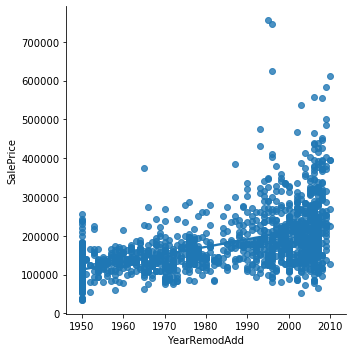

In [147]:
dbfilter = all_data[all_data['SalePrice'] > 0]
sns.lmplot(x='YearRemodAdd',y='SalePrice',data=dbfilter)